In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
from datetime import datetime
import matplotlib.pyplot as plt
from neural_analysis import spectra
import numpy as np
import sys
from tqdm.autonotebook import tqdm

sys.path.append('../..')
from nld_utils import simulate_lorenz
from reservoir_computing import ReservoirDS
from utils import save, load

### 1) Initialize Parameters

In [4]:
T = 125 # s, duration of time series
dt = 0.02 # s, time step
D_r = 300 # number of reservoir nodes
d = 6 # average degree of Erdos-Renyi network
rho = 1.2 # spectral radius of the adjacency matrix

beta = 0 # regularization parameter
# beta = 1e-4 # regularization parameter
sigma = 0.1 # maximum value of the input weights

# squared_inds = None
squared_inds = []
# squared_inds = np.random.choice(np.arange(D_r), size=(int(D_r/2),), replace=False)

var_names = ['x', 'y', 'z']

# initial_condition = None 
# initial_condition = (-8, -7, 29)
initial_condition = (-8.01304744, -6.58865759, 28.60202532)

### 2) Simulating the Lorenz Attractor

The equations that govern the Lorenz attractor are:

$$\frac{dx}{dt} = \sigma(y - x)$$

$$\frac{dy}{dt} = x(\rho - z) - y$$

$$\frac{dz}{dt} = xy - \beta z$$

where we set $\rho = 28$, $\beta = \frac{8}{3}$ and $\sigma = 10$ based on https://itp.uni-frankfurt.de/~gros/Vorlesungen/SO/simulation_example/.

In [5]:
lorenz_pts = simulate_lorenz(dt=dt, T=T, initial_condition=initial_condition)

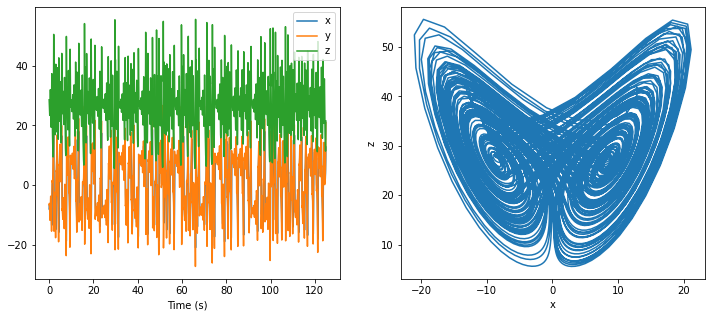

In [6]:
time_vals = np.arange(len(lorenz_pts))*dt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(time_vals, lorenz_pts[:, 0], label='x')
plt.plot(time_vals, lorenz_pts[:, 1], label='y')
plt.plot(time_vals, lorenz_pts[:, 2], label='z')
plt.xlabel('Time (s)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lorenz_pts[:, 0], lorenz_pts[:, 2])
plt.xlabel('x')
plt.ylabel('z')

plt.show()

### Build the Network

In [7]:
reservoir = ReservoirDS(lorenz_pts, dt=dt, D_r=D_r, d=d, rho=rho, beta=beta, sigma=sigma, squared_inds=squared_inds, var_names=var_names)

100%|██████████| 100/100 [00:05<00:00, 17.00it/s]


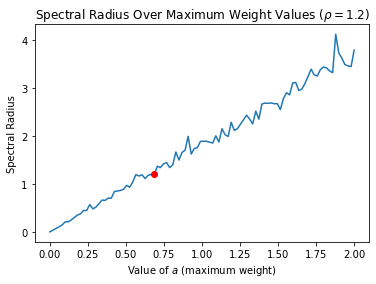

The spectral radius is 1.203


In [8]:
reservoir.build_connectivity(debug=True)

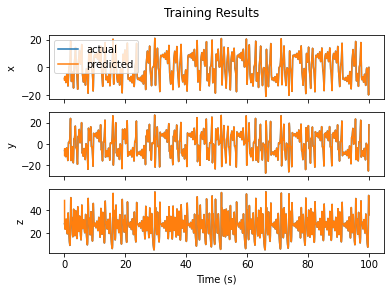

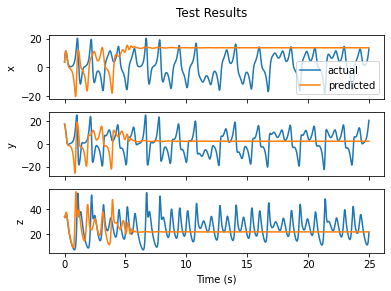

In [9]:
reservoir.train_and_test(debug=True)

In [190]:
# POWER SPECTRAL DENSITY

In [12]:
power_spectra = []
for i in range(reservoir.D):
    spec_true, freqs_true = spectra.spectrum(reservoir.u[reservoir.num_steps_train:, i], smp_rate=1/reservoir.dt, spec_type='power', freq_range=[0, 80])
    spec_test, freqs_test = spectra.spectrum(reservoir.v_test[:, i], smp_rate=1/reservoir.dt, spec_type='power', freq_range=[0, 80])
    power_spectra.append({'true': {'spec': spec_true, 'freqs': freqs_true}, 'test': {'spec': spec_test, 'freqs': freqs_test}, 'mse': ((spec_test - spec_true)**2).mean()})

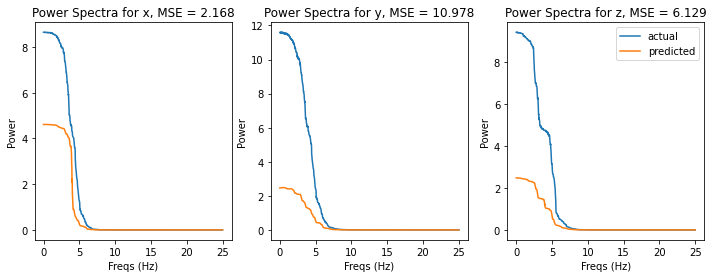

In [13]:
plt.figure(figsize=(12, 4))
for i in range(reservoir.D):
    plt.subplot(1, 3, i+1)
    plt.plot(power_spectra[i]['true']['freqs'], power_spectra[i]['true']['spec'], label='actual')
    plt.plot(power_spectra[i]['test']['freqs'], power_spectra[i]['test']['spec'], label='predicted')
    plt.title(f"Power Spectra for {reservoir.var_names[i]}, MSE = {power_spectra[i]['mse']:.3f}")
    plt.xlabel('Freqs (Hz)')
    plt.ylabel('Power')
plt.legend()
plt.show()

In [142]:
# timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
# save(reservoir, f'../../__data__/reservoir {timestamp}.pkl')

In [188]:
loading_filepath = "/Users/adameisen/Documents/MIT/2021 Summer/ChaoticConsciousness/__data__/reservoir 2021-06-11 12:27:21.pkl"
reservoir = load(loading_filepath)

## Jacobian

In [14]:
def sech(x):
    return 1/np.cosh(x)

def jacobian(reservoir):
    J = np.zeros((reservoir.num_steps_test, reservoir.D_r, reservoir.D_r))
    
    for t in range(-1, reservoir.num_steps_test - 1):
        if t < 0:
            r = reservoir.r_train[-1]
            v = reservoir.v_train[-1]
        else:
            r = reservoir.r_test[t]
            v = reservoir.v_test[t]

        D1 = np.diag(sech(reservoir.A @ r + reservoir.W_in @ v)**2)
        W_feedback = reservoir.W_in @ reservoir.P
        W_feedback[:, reservoir.squared_inds] *= 2*r[reservoir.squared_inds]
        D2 = reservoir.A + W_feedback
        J[t+1] = D1 @ D2
            
#     J = np.zeros((reservoir.num_steps_train, reservoir.D_r, reservoir.D_r))
    
#     for t in range(reservoir.num_steps_train):
#         r = reservoir.r_train[t]
#         v = reservoir.v_train[t]
            
#         D1 = np.diag(sech(reservoir.A @ r + reservoir.W_in @ v)**2)
#         W_feedback = reservoir.W_in @ reservoir.P
#         W_feedback[:, reservoir.squared_inds] *= 2*r[reservoir.squared_inds]
#         D2 = reservoir.A + W_feedback
#         J[t] = D1 @ D2
        
    return J

In [15]:
J = jacobian(reservoir)

In [28]:
def lyap_spectrum_QR(Js,T):
    K,n = Js.shape[0],Js.shape[-1]    
    old_Q = np.eye(n)
    H = np.eye(n)
    
    lexp  = np.zeros(n,dtype="float32")
    lexp_counts = np.zeros(lexp.shape)

    for t in range(K):
   
        
        # QR-decomposition of T * old_Q
        mat_Q, mat_R = np.linalg.qr(np.dot(Js[t], old_Q))
        # force diagonal of R to be positive
        # (if QR = A then also QLL'R = A with L' = L^-1)
        sign_diag = np.sign(np.diag(mat_R))
        sign_diag[np.where(sign_diag == 0)] = 1
        sign_diag = np.diag(sign_diag)
        mat_Q = np.dot(mat_Q, sign_diag)
        mat_R = np.dot(sign_diag, mat_R)

        old_Q = mat_Q
        
        # successively build sum for Lyapunov exponents
        diag_R = np.diag(mat_R)
        
        # filter zeros in mat_R (would lead to -infs)
        idx = np.where(diag_R > 0)
        lexp_i = np.zeros(diag_R.shape, dtype="float32")
        lexp_i[idx] = np.log(diag_R[idx])
        lexp_i[np.where(diag_R == 0)] = np.inf

        lexp[idx] += lexp_i[idx]
        lexp_counts[idx] += 1

            


    # it may happen that all R-matrices contained zeros => exponent really has
    # to be -inf

    # normalize exponents over number of individual mat_Rs
    idx = np.where(lexp_counts > 0)
    #lexp[idx] /= lexp_counts[idx]
    lexp[np.where(lexp_counts == 0)] = np.inf

    lexp /= T
    
    return lexp

In [29]:
J = jacobian(reservoir)
lyaps = lyap_spectrum_QR(J[1:], reservoir.num_steps_test*reservoir.dt)

In [30]:
lyaps

array([   9.247246 ,    7.55079  ,    1.5286824,    0.9947918,
         -0.5257621,   -7.793945 ,  -15.631867 ,  -15.9342375,
        -17.490341 ,  -18.906546 ,  -19.23625  ,  -20.396265 ,
        -21.271051 ,  -21.711891 ,  -22.407042 ,  -25.087183 ,
        -26.694998 ,  -26.985703 ,  -27.210005 ,  -27.545044 ,
        -27.888401 ,  -28.070566 ,  -28.857847 ,  -29.05446  ,
        -29.844324 ,  -30.07815  ,  -32.35759  ,  -32.290127 ,
        -32.471104 ,  -33.411163 ,  -33.818966 ,  -33.847176 ,
        -34.156574 ,  -34.20828  ,  -34.52399  ,  -34.62564  ,
        -35.502342 ,  -37.488796 ,  -37.34938  ,  -39.13676  ,
        -39.368763 ,  -41.65085  ,  -41.872353 ,  -42.552025 ,
        -42.740025 ,  -44.923653 ,  -45.168957 ,  -45.170757 ,
        -45.379383 ,  -46.21055  ,  -46.266544 ,  -46.9111   ,
        -46.977955 ,  -47.820328 ,  -48.03261  ,  -48.88083  ,
        -48.944775 ,  -49.72208  ,  -49.83098  ,  -50.469215 ,
        -50.648155 ,  -50.74644  ,  -51.220234 ,  -51.3